### Installing and importing the necessary libraries

In [3]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

### Loading a template for the final project

In [2]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


## Formalising the task and suggestion the evaluation criterion

First of all, let us explore which features are presented in the dataset and are there any features with null values:

In [3]:
full_dataset.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      5
language                   439
director                    24
writer                     808
production_company        2744
actors                      30
description               1993
avg_vote                     0
votes                        0
budget                   43379
usa_gross_income         48306
worlwide_gross_income    41062
metascore                51386
reviews_from_users        4069
reviews_from_critics      8229
dtype: int64

### Choosing a target variable

We should choose a target variable in order to measure success of each film in the data. There are different ways to measure the success of the film. 

For example, we could take income or budget, or evaluate the profit of the company, because more successful film will bring more money to the company, as more people would like to watch it. But there is a problem: all features, connected with income and budget consists lots of null values. So, focusing on these variables, we will not get a reliable result. 

There is another one option: we could measure the success choosing average vote as a target variable. Firstly, this feature does not include any null values. Secondly, this feature shows how different people evaluated the film. It is also an average indicator formed on a scale from 1 to 10 points. Therefore, the indicator allows us to compare films objectively. The better average vote is, the more people liked it, the more money company could earn on this film. 

But predicting exact average vote is quite a difficult task, because it depends on so many unpredictable factors. Therefore, it would much more better to divide average votes into categories, showing the success level of the film. We will use 3 categories:

- high, if average vote eaquals to 7 and more;
- middle, if average vote eaquals to 5 and more, but less than 7;
- low, if average vote less than 5. 

The film-producing company can the success level to make their decision: if predicting shows that film belongs to midlle or high category, it means that film with a higher probability is successfull. Otherwise, film not as good.

### Task to solve and metric 

We are going to solve classification task, because our goal is to determine which category each movie belongs to. 

Accuracy will be a metric for our classification task, because we want to estimate, how many of predictions are correct. Accuracy will work well with our dataset due to the fact that it is pretty balanced (having samples for all classes). 

Text(0.5, 1.0, 'Distirbution of the target variable')

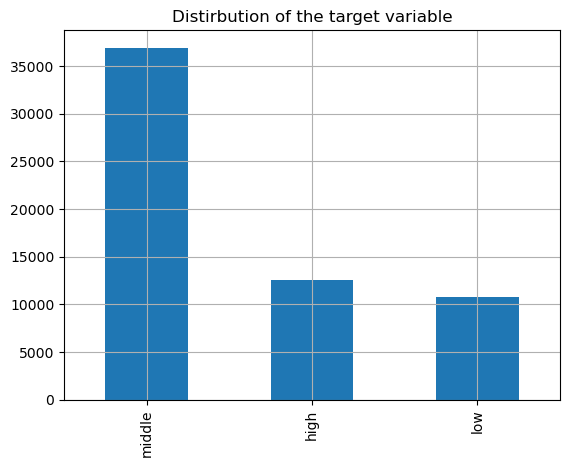

In [4]:
full_dataset['success_level'] = full_dataset['avg_vote']
full_dataset['success_level'] = full_dataset['success_level'].apply(lambda x: 'high' if x>=7.0 else x)
full_dataset['success_level'] = full_dataset['success_level'].apply(lambda x: 'middle' if type(x)==float and x>=5.0 and x<7.0 else x)
full_dataset['success_level'] = full_dataset['success_level'].apply(lambda x: 'low' if type(x)==float and x<5.0 else x)

full_dataset.success_level.value_counts().plot(kind='bar')
plt.grid()
plt.title('Distirbution of the target variable')

## Explore and preprocess the data 

This is a list of features presented in the dataset:

In [5]:
print (list(full_dataset.columns))

['imdb_title_id', 'title', 'original_title', 'year', 'date_published', 'genre', 'duration', 'country', 'language', 'director', 'writer', 'production_company', 'actors', 'description', 'avg_vote', 'votes', 'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore', 'reviews_from_users', 'reviews_from_critics', 'success_level']


The features 'title' and 'original title' are consists of similar information, so we can drop on of them. Also it is pretty difficult to compare different films by titles. We can assume that length of title can effect the attractiveness of the film for viewers. So, let us create new numerical feature 'title_length' and drop columns 'title' and 'original title'. 

In [6]:
full_dataset['title_length'] = full_dataset['title'].apply(lambda x: len(x))

We can also drop features: 'imdb_title_id', 'date_published', 'language', 'description'. These features do not have an important information which can influence the success level, or even if they have, this impact can not be easily evaluated. 

In [7]:
full_dataset = full_dataset.drop(['imdb_title_id', 'title', 'original_title', 'date_published',
                                  'language', 'description'], axis=1)

Then we will explore the column 'genre'. Firstly, let us see how many unique values there are:

In [8]:
len(full_dataset['genre'].unique())

1202

There are so many unique values due to the fact, that each value consists of few genres. We will extract only the fist one genre in order to have few categories for this feature. Moreover, only genres which repeated more than 500 times would be left. Other genres will be assigned to the category 'Other'. Then we can drop the column 'genre'.

In [9]:
full_dataset['main_genre'] = full_dataset.genre.str.extract(r"([a-zA-Z]+)")[0]
proper_genres = np.array(full_dataset['main_genre'].value_counts()[full_dataset['main_genre'].value_counts()>=500].index)
full_dataset['main_genre'] = full_dataset['main_genre'].apply(lambda x: 'Other' if x not in proper_genres else x)
full_dataset = full_dataset.drop(['genre'], axis=1)

Columns 'director' and 'writer' also will be dropped as they include lots of different velues which can not be compared. We will leave the feature 'production company', because we suppose, that production company more informative and influence both on writer and director who works with this film. Also more famous production company can be more attractive for viewers. In order to compare companies, we will split them into 4 categories:
- very famous (presented more than 500 times in the dataset);
- famous (presented more than 100 and less than500 times in the dataset);
- not very famous (presented more than 20 and less than 100 times in the dataset);
- not famous (presented less than 20 times in the dataset).

In [10]:
full_dataset['production_company_popularity'] = full_dataset['production_company']

proper_companies = np.array(full_dataset['production_company'].value_counts()[full_dataset['production_company'].value_counts()>=500].index)
full_dataset['production_company_popularity'] = full_dataset['production_company_popularity'].apply(lambda x: 'very famous' if x in proper_companies else x)


proper_companies_fam = np.array(full_dataset['production_company'].value_counts()[(full_dataset['production_company'].value_counts()<500) & (full_dataset['production_company'].value_counts()>=100)].index)
full_dataset['production_company_popularity'] = full_dataset['production_company_popularity'].apply(lambda x: 'famous' if x in proper_companies_fam else x)

proper_companies_not_very_fam = np.array(full_dataset['production_company'].value_counts()[(full_dataset['production_company'].value_counts()<100) & (full_dataset['production_company'].value_counts()>=20)].index)
full_dataset['production_company_popularity'] = full_dataset['production_company_popularity'].apply(lambda x: 'not very famous' if x in proper_companies_not_very_fam else x)

proper_companies_not_fam = np.array(full_dataset['production_company'].value_counts()[full_dataset['production_company'].value_counts()<20].index)
full_dataset['production_company_popularity'] = full_dataset['production_company_popularity'].apply(lambda x: 'not famous' if x in proper_companies_not_fam else x)

In [11]:
full_dataset = full_dataset.drop(['director', 'writer', 'production_company'], axis=1)

In [12]:
full_dataset['production_company_popularity'].unique()

array(['not famous', 'not very famous', 'famous', nan, 'very famous'],
      dtype=object)

There are so many unique values in the column 'country', because some values include few countries. We will extract only the fist one country in order to have few categories for this feature. Only countries which repeated more than 1000 times would be left. Other countries will be assigned to the category 'Other'. Then we can drop the column 'country'.

In [13]:
full_dataset['main_country'] = full_dataset.country.str.extract(r"([a-zA-Z]+)")[0]
proper_countries = np.array(full_dataset['main_country'].value_counts()[full_dataset['main_country'].value_counts()>=1000].index)
full_dataset['main_country'] = full_dataset['main_country'].apply(lambda x: 'Other' if x not in proper_countries else x)
full_dataset = full_dataset.drop(['country'], axis=1)

For the same reasons we will extract one actor from the feature 'actors' and split the extrected values into 4 categories:
- very famous (presented more than 50 times in the dataset);
- famous (presented more than 20 and less than 50 times in the dataset);
- not very famous (presented more than 3 and less than 20 times in the dataset);
- not famous (presented less than 3 times in the dataset).

In [14]:
full_dataset['main_actor'] = full_dataset.actors.str.extract(r"([^,]+)(\,)")[0]
full_dataset['main_actor_popularity'] = full_dataset['main_actor']

proper_actors_very_fam = np.array(full_dataset['main_actor'].value_counts()[full_dataset['main_actor'].value_counts()>=50].index)
full_dataset['main_actor_popularity'] = full_dataset['main_actor_popularity'].apply(lambda x: 'very famous' if x in proper_actors_very_fam else x)

proper_actors_fam = np.array(full_dataset['main_actor'].value_counts()[(full_dataset['main_actor'].value_counts()<50) & (full_dataset['main_actor'].value_counts()>=20)].index)
full_dataset['main_actor_popularity'] = full_dataset['main_actor_popularity'].apply(lambda x: 'famous' if x in proper_actors_fam else x)

proper_actors_not_very_fam = np.array(full_dataset['main_actor'].value_counts()[(full_dataset['main_actor'].value_counts()<20) & (full_dataset['main_actor'].value_counts()>=3)].index)
full_dataset['main_actor_popularity'] = full_dataset['main_actor_popularity'].apply(lambda x: 'not very famous' if x in proper_actors_not_very_fam else x)

proper_actors_not_fam = np.array(full_dataset['main_actor'].value_counts()[full_dataset['main_actor'].value_counts()<3].index)
full_dataset['main_actor_popularity'] = full_dataset['main_actor_popularity'].apply(lambda x: 'not famous' if x in proper_actors_not_fam else x)

In [15]:
full_dataset = full_dataset.drop(['actors', 'main_actor'], axis=1)

Then null values in the dataset ca be explored. Let us evaluate the percentage of the null values in each feature:

In [16]:
(full_dataset .isna().sum() / len(full_dataset )).round(4) * 100

year                              0.00
duration                          0.00
avg_vote                          0.00
votes                             0.00
budget                           72.06
usa_gross_income                 80.25
worlwide_gross_income            68.21
metascore                        85.36
reviews_from_users                6.76
reviews_from_critics             13.67
success_level                     0.00
title_length                      0.00
main_genre                        0.00
production_company_popularity     4.56
main_country                      0.00
main_actor_popularity             0.15
dtype: float64

We can illustrate fullness of each column by bar chart: 

<AxesSubplot:>

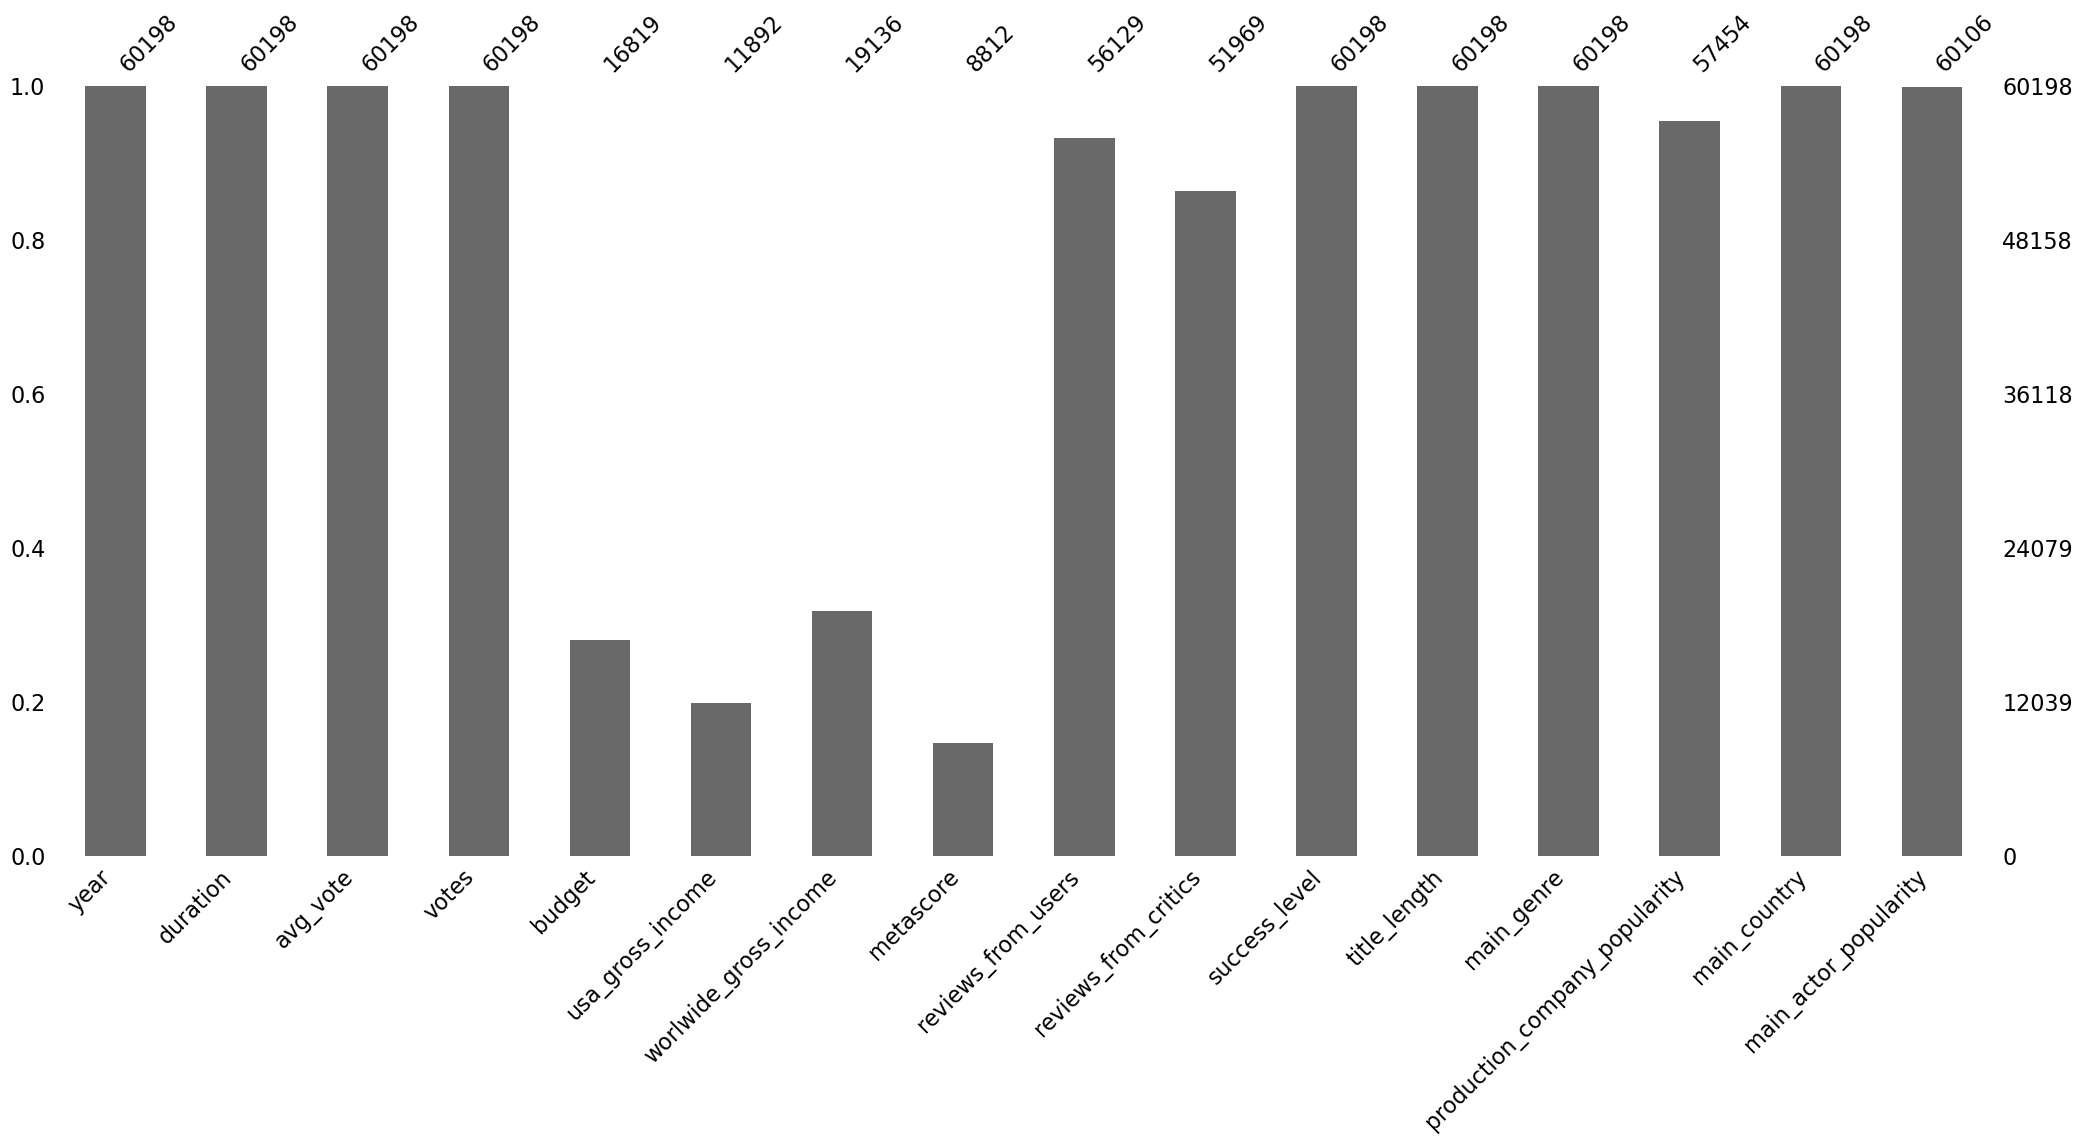

In [17]:
import missingno as msno
msno.bar(full_dataset)

As far as we can see, the least informative are columns 'usa_gross_income' and 'metascore', they include more than 80% of null values. So, we will drop these columns. 

In [18]:
full_dataset = full_dataset.drop(['usa_gross_income', 'metascore'], axis=1)

The null values in the columns 'main_actor_popularity' and 'production_company_popularity' will be replaced with the most frequent values.

In [19]:
full_dataset['production_company_popularity'] = full_dataset['production_company_popularity'].replace([None, np.nan, ''], None)
most_frequent_number = full_dataset['production_company_popularity'].mode()[0]          
full_dataset['production_company_popularity'].fillna(most_frequent_number, inplace = True)

In [20]:
most_frequent = full_dataset['main_actor_popularity'].mode()[0]     
full_dataset['main_actor_popularity'].fillna(most_frequent, inplace = True)

Then we will explore what kind of the data is presented in the dataset.

In [21]:
full_dataset.dtypes

year                               int64
duration                           int64
avg_vote                         float64
votes                              int64
budget                            object
worlwide_gross_income             object
reviews_from_users               float64
reviews_from_critics             float64
success_level                     object
title_length                       int64
main_genre                        object
production_company_popularity     object
main_country                      object
main_actor_popularity             object
dtype: object

Colunbs 'budget' and 'worlwide_gross_income' will be transformed to the numeric.

In [22]:
full_dataset['budget'] = full_dataset.budget.str.extract(r"(\d+)")[0]
full_dataset['worlwide_gross_income'] = full_dataset.worlwide_gross_income.str.extract(r"(\d+)")[0]
convert_dict = {'budget': float,
                'worlwide_gross_income': float
                }
 
full_dataset = full_dataset.astype(convert_dict)

As a result, we will create a list of categorical columns. For all of them we will use one hot ecnoding. Also we will create a list of numeric columns, for them a standard scaler will be applied.

In [23]:
categ_columns = ['main_genre', 'production_company_popularity', 'main_country', 'main_actor_popularity']
num_cols = ['year','duration','votes','title_length']

In order to fill in missing values in the columns 'budget', 'worlwide_gross_income', 'reviews_from_users', 'reviews_from_critics' we will use MeanGroupImputer. This function will return mean value in each group. Each feature will be group according to the popularity of the production company, as it influence these fatures more then other indicators. 

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
class MeanGroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using mean value within group
    
    Parameters
    ----------    
    group_cols : str
        A column used to calculate the mean values
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_col):
        assert type(group_col) == str, 'group_col should be a string'

        self.group_col = group_col
    
    def fit(self, X, y=None):
        assert X[self.group_col].isna().sum() == 0, 'There are missing values in the group_col'
        
        # Group dataset by `group_col` and calculate mean value of all the other columns within this group
        self.mapping = X.groupby(self.group_col).mean()
        return self 
    
    def transform(self, X, y=None):
        X = X.copy()
        # make sure that the imputer was fitted
        assert self.mapping is not None
        
        
        
        # loop over all the groups
        for index, row in self.mapping.iterrows():
            
            # Fill in missing values for the group `index` with the values `row`            
            try:
                indexes = list(X.groupby(self.group_col).groups[index])
                for el in list(row.index):
                    for i in indexes:
                        if pd.isnull(X[el][i]):
                            X.at[i, el] = row[el]
            except KeyError:
                continue
        
        # Then drop grouping column (we did not transform it, so it is not needed anymore)
        X.drop(self.group_col, axis=1, inplace=True)
        return X.values

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

mean_group_pipe = make_pipeline(MeanGroupImputer('production_company_popularity'),
                     StandardScaler())
num_pipe = make_pipeline (StandardScaler())
categ_pipe = make_pipeline (OneHotEncoder())

# Combine all three pipelines in one column transformer
column_transformer = ColumnTransformer([
    ('reviews_from_users', mean_group_pipe, ['reviews_from_users', 'production_company_popularity']),
    ('reviews_from_critics', mean_group_pipe, ['reviews_from_critics', 'production_company_popularity']),
    ('budget', mean_group_pipe, ['budget', 'production_company_popularity']),
    ('worlwide_gross_income', mean_group_pipe, ['worlwide_gross_income', 'production_company_popularity']),
    ('scaling', num_pipe, num_cols), 
    ('OHE', categ_pipe, categ_columns)],
remainder='passthrough')

### Split data into train and test

In [26]:
from sklearn.model_selection import train_test_split

tr, te = train_test_split(full_dataset, test_size=0.2, random_state=42)

y_train = tr.success_level
y_test = te.success_level
X_train = tr.drop(['avg_vote', 'success_level'], axis=1)
X_test = te.drop(['avg_vote', 'success_level'], axis=1)

## Train the models

The first one model - logistic regression.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_reg_pipe = Pipeline([
    ('transform', column_transformer),
    ('clf', LogisticRegression(penalty='none', max_iter = 200))
])

log_reg_score = cross_val_score(log_reg_pipe, X_train, y_train, scoring='accuracy', cv=5)

In [54]:
print(log_reg_score)

[0.6728613  0.66943522 0.67473007 0.66462465 0.67303499]


The second model - SVC.

In [56]:
from sklearn.svm import SVC

svm_pipe = Pipeline([
    ('transform', column_transformer),
    ('model', SVC(kernel='linear'))
])

svm_score = cross_val_score(svm_pipe, X_train, y_train, scoring='accuracy', cv=5)

In [57]:
print(svm_score)

[0.63372093 0.63299419 0.63091777 0.63472121 0.63679784]


The third model - DecisionTreeClassifier.

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

tree_pipe = Pipeline([
    ('transform', column_transformer),
    ('model', DecisionTreeClassifier())
])



tree_pipe_score = cross_val_score(tree_pipe, X_train, y_train, scoring='accuracy', cv=5)

In [62]:
tree_pipe_score

array([0.61949751, 0.61607143, 0.62292359, 0.61810819, 0.62060015])

We will use GridSearch to tune estimators's parameters and CrossVal to compute cross validated metrics for the model with better scores - logistic regression.

In [39]:
from sklearn.model_selection import GridSearchCV


pipe = Pipeline([
    ('preprocess', column_transformer),
    ('clf', 'passthrough')
])
    
    
parameters = [
    {
        'clf':[LogisticRegression(max_iter = 200)],
        'clf__C':[0.1, 1, 10],
        'clf__penalty': ['l2']
    },
    {
        'clf':[LogisticRegression(max_iter = 200)],
        'clf__penalty': ['none']
    },
]
    
grid_pipe = GridSearchCV(pipe, param_grid=parameters,
                      cv=5, 
                      scoring = 'accuracy')

grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('reviews_from_users',
                                                                         Pipeline(steps=[('meangroupimputer',
                                                                                          MeanGroupImputer(group_col='production_company_popularity')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['reviews_from_users',
                                                                          'production_company_popularity']),
                                                               

In [40]:
print(grid_pipe.best_score_)
print(grid_pipe.best_estimator_.steps[1][1])

0.6707088750991314
LogisticRegression(C=10, max_iter=200)


### Evaluating the best model on test

Now, we can use the best estimator to evaluate model on the test dataset. 

In [41]:
from sklearn.metrics import accuracy_score

grid_pipe.best_estimator_.fit(X_train, y_train)
y_pred = grid_pipe.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.6714285714285714

### Conclusion

- Metric score is close to 70%. That means that model is quite accurate, its performance is not so high. It will make mistakes in 3 cases of 10. 
- Clients needs were achieved, beacuse model can be helpful in predicting success level of the film. 
- Better performence of the model can be achieved if the information in such columns as 'genre' and 'actors' contained the initially selected main genre and the main actor. The model will also be improved if we take into account the description of the film and collect more data about the budget and income.